# Introduction 

The goal of this project is to investigate two aspects of multi-step-ahead forecasting of spatio-temporal data:

1. *Dynamic vs static models:* we will compare the performance of several static and dynamic models. The dynamic models all have a recurrent neural network as part of their architecture. In these models, the value of the time-series in the previous time-steps is used to derive the "state" of the recurrent netwok. The output of the recurrent network, then, is augmented to other features in the data to form the full set of features. In contrast, in the static models there is no recurrent archtucture and the value of the time-series at previous time-steps are augmented directly to the other features. 

2. *methods for splitting data:* we will examine the effect of different methods for splitting the data into train and validation on the performance of the trained model on the test data. Forming the validation set for time-seris data is more challenging than other cases. Specifically, many machine learning tasks can be considered as *interpolation*, where the range of the features in the train and test sets are similar. On the other hand, time-series forecasting (specially the multi-step ahead forecasting) is an *extrapolation* task. The question that we are intrested in is wheather this should be considered in forming the validation set. We will examine different methods for forming the valifation set.

We will examine these points on the [Recruit dataset](https://www.kaggle.com/c/recruit-restaurant-visitor-forecasting). This is a relational dataset which includes the daily number of visitors to a number of restaurants in Japan from 2016-01-01 to 2017-04-22. The goal is to forecast the number of visitors for these restaurants for the interval 2017-04-23 to 2017-05-31 (38 days). The quality of forecast is measured by root mean squared logarithmic error (RMSLE) defined as follows:

$$
RMSLE=\sqrt{\frac{1}{n} \sum_i (log(y_i+1)- log(\hat{y}_i+1))^2}
$$

where $y_i$ and $\hat{y}_i$ are the $i^{th}$ observation and estimated value, respectively.

In addition to the number of visitors, the dataset contains information about the longitude and latitude of the stores, the genre of the food they serve, the name of the neighberhood and the status of the date (holiday or not). These data are in three tables: visit_data (which contains number of visitors, store id and the date), store_info (which contains the information regariding the stores) and date_info (which contains information about the dates). There are a total of 252108 observation in the visti_data table which belongs to 829 stores.

# Exploratory data analysis 

In this section we perform some analysis to investigate the basic properties of the dataset. We start by examining the distribution of the number of visits:

In [1]:
#loading necessariy packages
import pandas as pd
import numpy as np
import matplotlib
%matplotlib inline 
import matplotlib.pyplot as plt
from matplotlib import pylab
matplotlib.style.use('ggplot')
from os.path import join

import recruit_config
dataDir = recruit_config.DATADIR#recruit_config contains some basic settings for this project
from utils import loadData,plotSpatialData,computeDist#utils contains some helper functions for loading,
#plotting and some computations on features.

In [2]:
#loading data into pandas dfs
dataDict=loadData(['air_reserve','air_store_info','air_visit_data',
                   'date_info'])
df_R,df_S,df_V,df_date=\
    (dataDict['air_reserve'],dataDict['air_store_info'],
     dataDict['air_visit_data'],dataDict['date_info'])
df_test=pd.read_csv(join(dataDir,'test.csv'),parse_dates=['visit_date']) 
df_date.rename(columns={'calendar_date':'visit_date'},inplace=True)

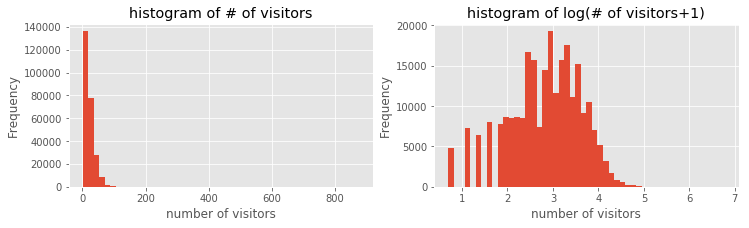

In [3]:
fig=plt.figure(figsize=(12,3))
fig.add_subplot(121)
df_V.visitors.plot.hist(bins=50)
plt.xlabel('number of visitors');plt.title('histogram of # of visitors')

fig.add_subplot(122)
np.log1p(df_V.visitors).plot.hist(bins=50)
_=plt.xlabel('number of visitors');plt.title('histogram of log(# of visitors+1)');

The left panel shows the number of visitors. As we can see it has a highly skewed distribution. Also there are a few outliers with large values. Skewed observations are problematic for many machine learning algorithms. Therefor we will work with the log of the observation plus one, the histogram of which is shown in the right panel.

Next, we investigate the spatial distribution of the number of visits. The following figure shows the mean  number of visits in different locations in non-holidays (left) and holidays (right):

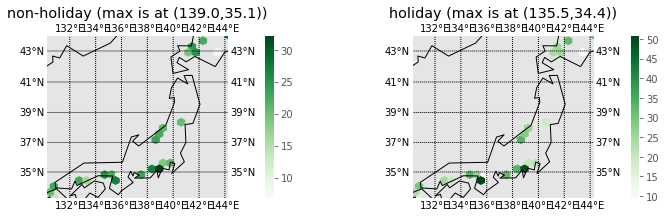

In [4]:
df=df_V.merge(df_S,on=['air_store_id']).merge(df_date,on='visit_date')
df1=df[df.holiday_flg==0];df2=df[df.holiday_flg==1];

fig=plt.figure(figsize=(12,3))
#non-holiday
fig.add_subplot(121)
lon_max,lat_max=plotSpatialData(x=df1.longitude.get_values(),y=df1.latitude.get_values(),
                C=df1.visitors.get_values(),reduce_C_function=np.mean)
plt.title('non-holiday (max is at ({:.1f},{:.1f}))'.format(lon_max,lat_max),position=(.5,1.07));

#holidays
fig.add_subplot(122)
lon_max,lat_max=plotSpatialData(x=df2.longitude.get_values(),y=df2.latitude.get_values(),
                C=df2.visitors.get_values(),reduce_C_function=np.mean)
plt.title('holiday (max is at ({:.1f},{:.1f}))'.format(lon_max,lat_max),position=(.5,1.07));

Interestingly, the average number of visitors increases in the holidays but the shape of the distribution remains more or less the same. To investigate this more, in the following figure we plot the average number of visitors for each area_name in holidats vs. non-holidays. As we can see, for most areas holidays are busier (the blus line is y=x).

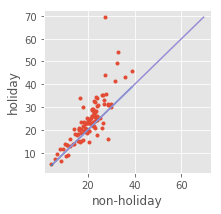

In [5]:
fig=plt.figure(figsize=(3,3))
means=pd.pivot_table(data=df,index='air_area_name',columns='holiday_flg',values='visitors',aggfunc=np.mean)

plt.plot(means[0],means[1],'.')
plt.plot([means.min(),means.max()],[means.min(),means.max()])
plt.xlabel('non-holiday');plt.ylabel('holiday');

The average number of visitors as a function of day of week and hour of day is shown below:

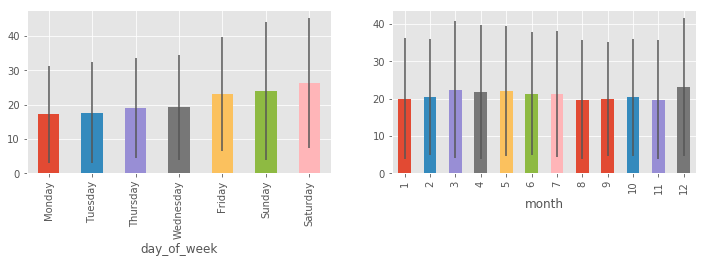

In [8]:
fig=plt.figure(figsize=(12,3))
fig.add_subplot(121)
means=df.groupby('day_of_week').visitors.mean()
err=df.groupby('day_of_week').visitors.std()
means.sort_values().plot.bar(yerr=err);

fig.add_subplot(122)
means=df.groupby(df.visit_date.dt.month).visitors.mean()
err=df.groupby(df.visit_date.dt.month).visitors.std()
means.plot.bar(yerr=err);
plt.xlabel('month');

Finally, the effect of the genre_name is hown below. The most popular stores are those who serve Asian food. Also, for most genres, holodays is only slightly busier. 

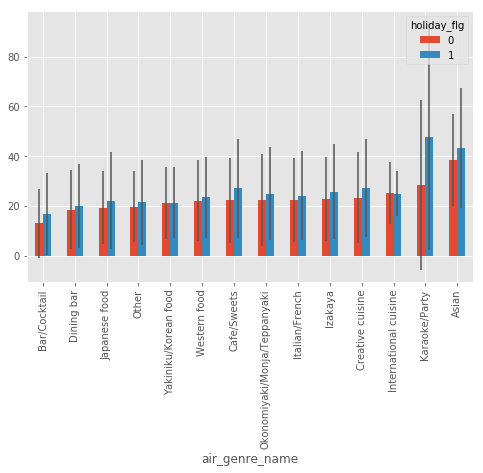

In [90]:
means=pd.pivot_table(data=df,index='air_genre_name',columns='holiday_flg',values='visitors',aggfunc=np.mean)
err=pd.pivot_table(data=df,index='air_genre_name',columns='holiday_flg',values='visitors',aggfunc=np.std)

means.sort_values(by=0).plot.bar(yerr=err,figsize=(8,5));

# Splitting the training data 

<a id='split'></a>
As we mentioned in the [Introduction](#Introduction), we need to decide on how to split the train data for training and validation. We consider three approaches here:

1. We use any observation in the range '2016-01-01' to '2017-02-03' to extract the features for the training set, and use the observation in the '2017-02-04' to '2017-03-14' as the target values of the train set. We also, use all the data in the range '2016-01-01' to '2017-03-14' to extract the features for the validation set and use the observations in the range '2017-03-15' to '2017-04-22' as the target values of the validation set. We finally use the data in the range '2016-01-01' to '2017-04-22' (all available data in the train set) to extract the features for the test set. The diagram below clarifies this method for splitting the data. The red area is used to extract train features, the greean area is used as the train targets, the union of red and green is used to extract validation features, and the gray area is used as the validation target. Using this method, we respect the extrapolation nature of the problem: the target values in the validation set are from time stamps later than those in the train set. 
<img src="./Figures/train_vald_split.bmp" width="300" height="300" id='fig1'/>
<h4><center>Figure 1</center></h4>
2. In the second method, we use all observation in the union of the red and green areas to compute the features, and the observations in the gray area as the target values. Then, we randomly sample 10% of the observations in the gray area as the validation set and the remaining as the train set. Here, we are treating the problem as an interpolation problem, because for an observation in the validation set which corresponds to say time $t_0$, the observations at $t_0-1$ and/or $t_0+1$ might be in the train set.
3. In this method, we first sample 10% of the data as validation. Then we use all remaining part of the data to compute the featuers. As we will see in the next section, some of the features are obtained by computing the average number of visitors in different groups (e.g., for each month). Thus, using this method in computing the feature values we are using the target values in the validation set and so there is a considarable *data leakage*. 

# Features 

We use the following set of features in all models:

+ **Categorical features:** one-hot encoded values of `air_genre_name` and `air_area_name`.
+ **Longitude and latitude:** of the stores scaled to standard normal.
+ **Date-realted features:** year, month, day, day of week, if the date was holoday, and if the date was * Golden week*. 

These features were already in the dataset. To enrich the features we add the following set of features:

+ Average number of visits grouped by store and each of the following: month , day and week day. 

+ Average number of visits grouped by `air_genre_name` and `air_area_name`. 

+ Number of visits for each store in the last $n$ available days, where $n$ was considered as a hyper-parameter tuned by cross-validation. Note that for each store we need to perform 1-,2-, ...,38-step ahead forecast. For each of these cases we used the latest $n$ available days.

+ prediction horizon: this is a multi-step ahead forecasting problem. So each sample in the test set could be a 1-, 2-,...,38-step ahead of the latest observation. We add this prediction horizon as a feature. This is particullary useful for models which use the previous observations as the features, because the prediction horizon specifies how much these information are relevant.

# Models 

The models we consider differ in the algorithm used, the method of forming the validation set, and the features they use. [Table 1](#tab1) summerized these models.

**Model 1:** this is the simplest model and we use it as the baseline. This model does not use any of the features obtained by averaging and only uses the features which were already in the raw dataset. Here we use the third method for forming the train and validation sets. We used [lightGBM](https://github.com/Microsoft/LightGBM) as the predictive model.

**Model 2, 3, 4:** like model 1 we used lightGBM as the predictive model. However, in these models in addition to the basic features, we use the features obtained by averaging grouped data (see [Features](#Features)). These three models differ in the method used for forming the validation set (see [Table 1](#tab1)).

**Model 5:** This model is similar to model 1 with the only difference being that in this model in addition to the basic features and the grouped averaged features, we also use the $n$ available previous observations as features (see [Featuers](#Features)).

**Model 6:** This model is the same as model 4 with the only difference that here we use xgboost as the algorithm.

**Model 7:** This is neural network architecture with two gully connected layers with tanh activation functions and a linear output node. The features are the same as those used in Model 5 and we used the first method for forming the validation set. The number of neurons in the hidden layers is the hyper-parameter of the model as is chosen using the error on the validation set. We implemented this and the next two models in [keras](https://keras.io).

**Model 8,9:** These two models are both dynamic, that is instead of using the previous observations directly as features, these observations are used as the input to LSTM units. The final output of these units, then is augmented with other features and is used as the input to two fully connected layers. Theses model differ in the method the validation set is formed.





<a id='tab1'></a>
\begin{array}{|c|c|}
\hline 
  Model & Algorithm & val.                    & features         & RMSLE \\\hline
  1     & lgbm      & 3                       & basic            & 0.720 \\\hline
  2     & lgbm      & 1                       & basic+avg        & 0.516 \\\hline
  3     & lgbm      & 2                       & basic+avg        & 0.530 \\\hline
  4     & lgbm      & 3                       & basic+avg        & 0.501 \\\hline
  5     & lgbm      & 1                       & basic+avg+prev   & 0.518 \\\hline
  \textbf{6}   & \textbf{xgb}   & \textbf{3}  & \textbf{basic+avg}  & \textbf{0.498} \\\hline
  7     & NN        & 1                       & basic+avg+prev   & 0.582 \\\hline
  8     & LSTM      & 1                       & basic+avg+prev   & 0.512 \\\hline
  9     & LSTM      & 3                       & basic+avg+prev   & 0.536 \\\hline  
\end{array}

# Model comparison 

[Table 1](#tab1) shows the performance of all the fitted models. We fitted each model to the train data and computed the prediction on the test set. The target values of the test set are not provided in the Recruit dataset. The predicted values were then submmited to the [Kaggle website](https://www.kaggle.com/c/recruit-restaurant-visitor-forecasting) which evaluates RMSLE on the test set. 

The first point to note is that the performance of all models is significantly superior to the baseline, Model 1. 
The best model is Model 6. This model is an xgboost, and the valiadtion set is formed using the third method, and it only used the basic and the grouped averaged features (and not the previous observations). The performance of this model is very close to Model 4 wihch uses the same features and same method for forming the validation set, but uses the LightGBM model. The fact that these models have achieved the best performance is interesting: both these models are using the third method for forming the validation set. As it was explained in the Section [Splitting the training data](#split), this method causes a large data leakage and theoritically should result in a biased estimate of the performance measure. However, emprically this method resulted in better performance than the other two methods on the test set.

Comparison of Models 4 and 5 shows that inclusion of the previous observation as features have hurt the performance. 

Model 7, which is a neural network with two fully connected layers has the worst performance. However, by adding a dynamic component we achieve a significant boost in the performance. Note that the only difference between Model 8, which has the third best performance, and Model 7 is that in Model 8 the previous observations are passed through a LSTM network and the output of this network is then augmented with other features.

# Analysing fitted model 

## Analysing prediction error

In this section, we analyse the quality of the best fitted model, Model 6. We fit the model on the dat corresponding to the union of the reg and green areas in [Figure 1](#fig1) and use the data of the gray area to compute the prediction error. [Figure 2](#fig2) shows this error as a function of several of the features. The goal here is to see if there is any pattern in the relationship between a specific feature and the error.
<img src="./Figures/prediction_error.jpg" width="600" height="300" id='fig2'/>
<h4><center>Figure 2</center></h4>

As we can see in this figure, the prediction error does not show any specific pattern (e.g., skewness, outliers and so on) as a function of the features. 

## Feature importance 

The feature importances are shown in the figure below. Average number of visitors grouped by month is the most important feature. In trestingly, the holoday flag is not an important featue. The most important features are all date related and not the related to food genre the store server and the neighborhood it is located at. 

<img src="./Figures/feature_importance.jpg" width="600" height="300" id='fig3'/>
<h4><center>Figure 3</center></h4>

## Model's prediction

Figure 4 shows the true (blue) and predicted (orange) values of the time-series of 4 randomly chosen stores. This figure shows both good (right) and poor (left) predictions. It is important to note that Model 6 does not use the observations in the previous time-steps as features. This figure suggests that augmenting the predictions of classical models of time-seris (e.g., ARIMA models) might help to improve the performace. Here, we do not consider this *model stacking* idea further. 

<img src="./Figures/ts_prediction.jpg" width="600" height="300" id='fig4'/>
<h4><center>Figure 4</center></h4>